In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler

pd.options.mode.copy_on_write = True

In [47]:
# This contains some functions written by the authors of the textbook (ISLP)
# we'll be adapting most of the this demo from their material

from ISLP import load_data, confusion_table
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)

In [48]:
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (mean_squared_error, 
                             r2_score, 
                             accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)

In [49]:
# Create helper functions for computing the mean squared error

def predict(X, model):
    # the built-in get_prediction tool returns an array, so we need to convert to a dataframe
    predictions_df = pd.DataFrame(model.get_prediction(X).predicted, columns=['y_hat'], index=X.index)
    return predictions_df['y_hat']

def mse(y, y_hat):
    # calculate the residual error for each individual record
    resid = y - y_hat
    # square the residual (hence "squared error")
    sq_resid = resid**2
    # calculate the sum of squared errors
    RSS = sum(sq_resid)
    # divide by the number of records to get the mean squared error
    MSE = RSS / y.shape[0]
    return MSE

In [50]:
# Load the data

StudentPerformanceFactors = load_data('/Users/stefanwang/Downloads/CSE 2600/Group Project/StudentPerformanceFactors')
StudentPerformanceFactors.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


In [51]:
StudentPerformanceFactors.dtypes

Hours_Studied                  int64
Attendance                     int64
Parental_Involvement          object
Access_to_Resources           object
Extracurricular_Activities    object
Sleep_Hours                    int64
Previous_Scores                int64
Motivation_Level              object
Internet_Access               object
Tutoring_Sessions              int64
Family_Income                 object
Teacher_Quality               object
School_Type                   object
Peer_Influence                object
Physical_Activity              int64
Learning_Disabilities         object
Parental_Education_Level      object
Distance_from_Home            object
Gender                        object
Exam_Score                     int64
dtype: object

In [52]:
StudentPerformanceFactors.shape

(6607, 20)

In [53]:
# Check if there is any missing value in each column/features of the data set:
StudentPerformanceFactors.isna().any()  # From the output,since there are three columns is True, we know there are missing values in the columns: Teacher_Quality, Parental_Education_Level, Distance_from_Home.

Hours_Studied                 False
Attendance                    False
Parental_Involvement          False
Access_to_Resources           False
Extracurricular_Activities    False
Sleep_Hours                   False
Previous_Scores               False
Motivation_Level              False
Internet_Access               False
Tutoring_Sessions             False
Family_Income                 False
Teacher_Quality                True
School_Type                   False
Peer_Influence                False
Physical_Activity             False
Learning_Disabilities         False
Parental_Education_Level       True
Distance_from_Home             True
Gender                        False
Exam_Score                    False
dtype: bool

In [54]:
# Remove all the rows with any missing value for each column/feature:
StudentPerformanceFactors = StudentPerformanceFactors.dropna().reset_index().drop(columns='index')

In [55]:
# Again, double check if there is any missing value in each column/features of the data set:
StudentPerformanceFactors.isna().any()     # From the output, We can see there is no more missing value in each column in the data set.

Hours_Studied                 False
Attendance                    False
Parental_Involvement          False
Access_to_Resources           False
Extracurricular_Activities    False
Sleep_Hours                   False
Previous_Scores               False
Motivation_Level              False
Internet_Access               False
Tutoring_Sessions             False
Family_Income                 False
Teacher_Quality               False
School_Type                   False
Peer_Influence                False
Physical_Activity             False
Learning_Disabilities         False
Parental_Education_Level      False
Distance_from_Home            False
Gender                        False
Exam_Score                    False
dtype: bool

In [56]:
StudentPerformanceFactors.shape   
# After delete all the rows with any missing values, we remain 6378 observations and 20 predictors/features/columns.

(6378, 20)

In [57]:
# Check if there is any outliers (the values that are out of the reasonable range of each feature/column) in our data set.
for column in StudentPerformanceFactors.columns:
        unique_values = np.unique(StudentPerformanceFactors[column])
        print(column, ":", unique_values)     # From the output, we can see there is no any outliers in our data set, since all the uniques values for each column/feature are all seems reasonable.

Hours_Studied : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 43 44]
Attendance : [ 60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100]
Parental_Involvement : ['High' 'Low' 'Medium']
Access_to_Resources : ['High' 'Low' 'Medium']
Extracurricular_Activities : ['No' 'Yes']
Sleep_Hours : [ 4  5  6  7  8  9 10]
Previous_Scores : [ 50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85
  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100]
Motivation_Level : ['High' 'Low' 'Medium']
Internet_Access : ['No' 'Yes']
Tutoring_Sessions : [0 1 2 3 4 5 6 7 8]
Family_Income : ['High' 'Low' 'Medium']
Teacher_Quality : ['High' 'Low' 'Medium']
School_Type : ['Private' 'Public']
Peer_Influence : ['Negative' 'Neutral' 'Positive

In [58]:
# Find all the categorical columns in our data set:

categorical_columns = []
for column_name in StudentPerformanceFactors.columns:
    if StudentPerformanceFactors[column_name].dtype != "int64":
        categorical_columns.append(column_name)

categorical_columns

['Parental_Involvement',
 'Access_to_Resources',
 'Extracurricular_Activities',
 'Motivation_Level',
 'Internet_Access',
 'Family_Income',
 'Teacher_Quality',
 'School_Type',
 'Peer_Influence',
 'Learning_Disabilities',
 'Parental_Education_Level',
 'Distance_from_Home',
 'Gender']

In [59]:
# Take a look at the counts of each unique values for all the Categorical Predictors in our data set:
for column_name in categorical_columns:
    print(StudentPerformanceFactors[column_name].value_counts())

Parental_Involvement
Medium    3251
High      1836
Low       1291
Name: count, dtype: int64
Access_to_Resources
Medium    3204
High      1900
Low       1274
Name: count, dtype: int64
Extracurricular_Activities
Yes    3807
No     2571
Name: count, dtype: int64
Motivation_Level
Medium    3237
Low       1864
High      1277
Name: count, dtype: int64
Internet_Access
Yes    5893
No      485
Name: count, dtype: int64
Family_Income
Low       2582
Medium    2566
High      1230
Name: count, dtype: int64
Teacher_Quality
Medium    3826
High      1905
Low        647
Name: count, dtype: int64
School_Type
Public     4434
Private    1944
Name: count, dtype: int64
Peer_Influence
Positive    2553
Neutral     2495
Negative    1330
Name: count, dtype: int64
Learning_Disabilities
No     5710
Yes     668
Name: count, dtype: int64
Parental_Education_Level
High School     3159
College         1939
Postgraduate    1280
Name: count, dtype: int64
Distance_from_Home
Near        3801
Moderate    1941
Far          

This output results indicate that there is no other missing values (eg. "?") in our data set.

In [60]:
# We use one hot encoding to generate dummy variables for all the Categorical Predictors:

one_hot = pd.get_dummies(StudentPerformanceFactors, columns = categorical_columns)   # 'pd.get_dummies()' method can Convert categorical variable into dummy/indicator variables.
one_hot

,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity,Exam_Score,Parental_Involvement_High,Parental_Involvement_Low,Parental_Involvement_Medium,...,Learning_Disabilities_No,Learning_Disabilities_Yes,Parental_Education_Level_College,Parental_Education_Level_High School,Parental_Education_Level_Postgraduate,Distance_from_Home_Far,Distance_from_Home_Moderate,Distance_from_Home_Near,Gender_Female,Gender_Male
0,23,84,7,73,0,3,67,False,True,False,...,True,False,False,True,False,False,False,True,False,True
1,19,64,8,59,2,4,61,False,True,False,...,True,False,True,False,False,False,True,False,True,False
2,24,98,7,91,2,4,74,False,False,True,...,True,False,False,False,True,False,False,True,False,True
3,29,89,8,98,1,4,71,False,True,False,...,True,False,False,True,False,False,True,False,False,True
4,19,92,6,65,3,4,70,False,False,True,...,True,False,True,False,False,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6373,25,69,7,76,1,2,68,True,False,False,...,True,False,False,True,False,False,False,True,True,False
6374,23,76,8,81,3,2,69,True,False,False,...,True,False,False,True,False,False,False,True,True,False
6375,20,90,6,65,3,2,68,False,False,True,...,True,False,False,False,True,False,False,True,True,False
6376,10,86,6,91,2,3,68,True,False,False,...,True,False,False,True,False,True,False,False,True,False


In [61]:
# Double check if all the categorical predictors were converted into dummy variables:

one_hot.columns

Index(['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores',
       'Tutoring_Sessions', 'Physical_Activity', 'Exam_Score',
       'Parental_Involvement_High', 'Parental_Involvement_Low',
       'Parental_Involvement_Medium', 'Access_to_Resources_High',
       'Access_to_Resources_Low', 'Access_to_Resources_Medium',
       'Extracurricular_Activities_No', 'Extracurricular_Activities_Yes',
       'Motivation_Level_High', 'Motivation_Level_Low',
       'Motivation_Level_Medium', 'Internet_Access_No', 'Internet_Access_Yes',
       'Family_Income_High', 'Family_Income_Low', 'Family_Income_Medium',
       'Teacher_Quality_High', 'Teacher_Quality_Low', 'Teacher_Quality_Medium',
       'School_Type_Private', 'School_Type_Public', 'Peer_Influence_Negative',
       'Peer_Influence_Neutral', 'Peer_Influence_Positive',
       'Learning_Disabilities_No', 'Learning_Disabilities_Yes',
       'Parental_Education_Level_College',
       'Parental_Education_Level_High School',
       'Parenta

In [62]:
one_hot.replace({True:1, False:0}, inplace=True)
one_hot

/var/folders/7j/1h6x9bj501b6z7n162zlh58c0000gn/T/ipykernel_7016/2596268218.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  one_hot.replace({True:1, False:0}, inplace=True)


,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity,Exam_Score,Parental_Involvement_High,Parental_Involvement_Low,Parental_Involvement_Medium,...,Learning_Disabilities_No,Learning_Disabilities_Yes,Parental_Education_Level_College,Parental_Education_Level_High School,Parental_Education_Level_Postgraduate,Distance_from_Home_Far,Distance_from_Home_Moderate,Distance_from_Home_Near,Gender_Female,Gender_Male
0,23,84,7,73,0,3,67,0,1,0,...,1,0,0,1,0,0,0,1,0,1
1,19,64,8,59,2,4,61,0,1,0,...,1,0,1,0,0,0,1,0,1,0
2,24,98,7,91,2,4,74,0,0,1,...,1,0,0,0,1,0,0,1,0,1
3,29,89,8,98,1,4,71,0,1,0,...,1,0,0,1,0,0,1,0,0,1
4,19,92,6,65,3,4,70,0,0,1,...,1,0,1,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6373,25,69,7,76,1,2,68,1,0,0,...,1,0,0,1,0,0,0,1,1,0
6374,23,76,8,81,3,2,69,1,0,0,...,1,0,0,1,0,0,0,1,1,0
6375,20,90,6,65,3,2,68,0,0,1,...,1,0,0,0,1,0,0,1,1,0
6376,10,86,6,91,2,3,68,1,0,0,...,1,0,0,1,0,1,0,0,1,0


In [63]:
one_hot.shape

(6378, 41)

In [64]:
# Identify some predictors (as x) and a target (as y), and add an intercept column (with all values equal to 1) into the object x.

design = MS(one_hot.columns.drop(["Exam_Score"]))
x = design.fit_transform(one_hot)
y = one_hot["Exam_Score"]

In [65]:
# Split the whole data set into training set and testing sets (training set with 80% observations; testing set with 20% observations):

x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    random_state=314,
                                                    test_size=0.20,
                                                    shuffle=True) 
Train = pd.merge_ordered(x_train,y_train,left_on=x_train.index,right_on=y_train.index).drop(columns=['key_0'])
Test = pd.merge_ordered(x_test,y_test,left_on=x_test.index,right_on=y_test.index).drop(columns=['key_0'])

Train

,intercept,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity,Parental_Involvement_High,Parental_Involvement_Low,Parental_Involvement_Medium,...,Learning_Disabilities_Yes,Parental_Education_Level_College,Parental_Education_Level_High School,Parental_Education_Level_Postgraduate,Distance_from_Home_Far,Distance_from_Home_Moderate,Distance_from_Home_Near,Gender_Female,Gender_Male,Exam_Score
0,1.0,23,84,7,73,0,3,0,1,0,...,0,0,1,0,0,0,1,0,1,67
1,1.0,19,64,8,59,2,4,0,1,0,...,0,1,0,0,0,1,0,1,0,61
2,1.0,24,98,7,91,2,4,0,0,1,...,0,0,0,1,0,0,1,0,1,74
3,1.0,29,89,8,98,1,4,0,1,0,...,0,0,1,0,0,1,0,0,1,71
4,1.0,19,92,6,65,3,4,0,0,1,...,0,1,0,0,0,0,1,1,0,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5097,1.0,20,83,6,51,2,4,0,0,1,...,0,0,1,0,0,1,0,1,0,65
5098,1.0,23,76,8,81,3,2,1,0,0,...,0,0,1,0,0,0,1,1,0,69
5099,1.0,20,90,6,65,3,2,0,0,1,...,0,0,0,1,0,0,1,1,0,68
5100,1.0,10,86,6,91,2,3,1,0,0,...,0,0,1,0,1,0,0,1,0,68


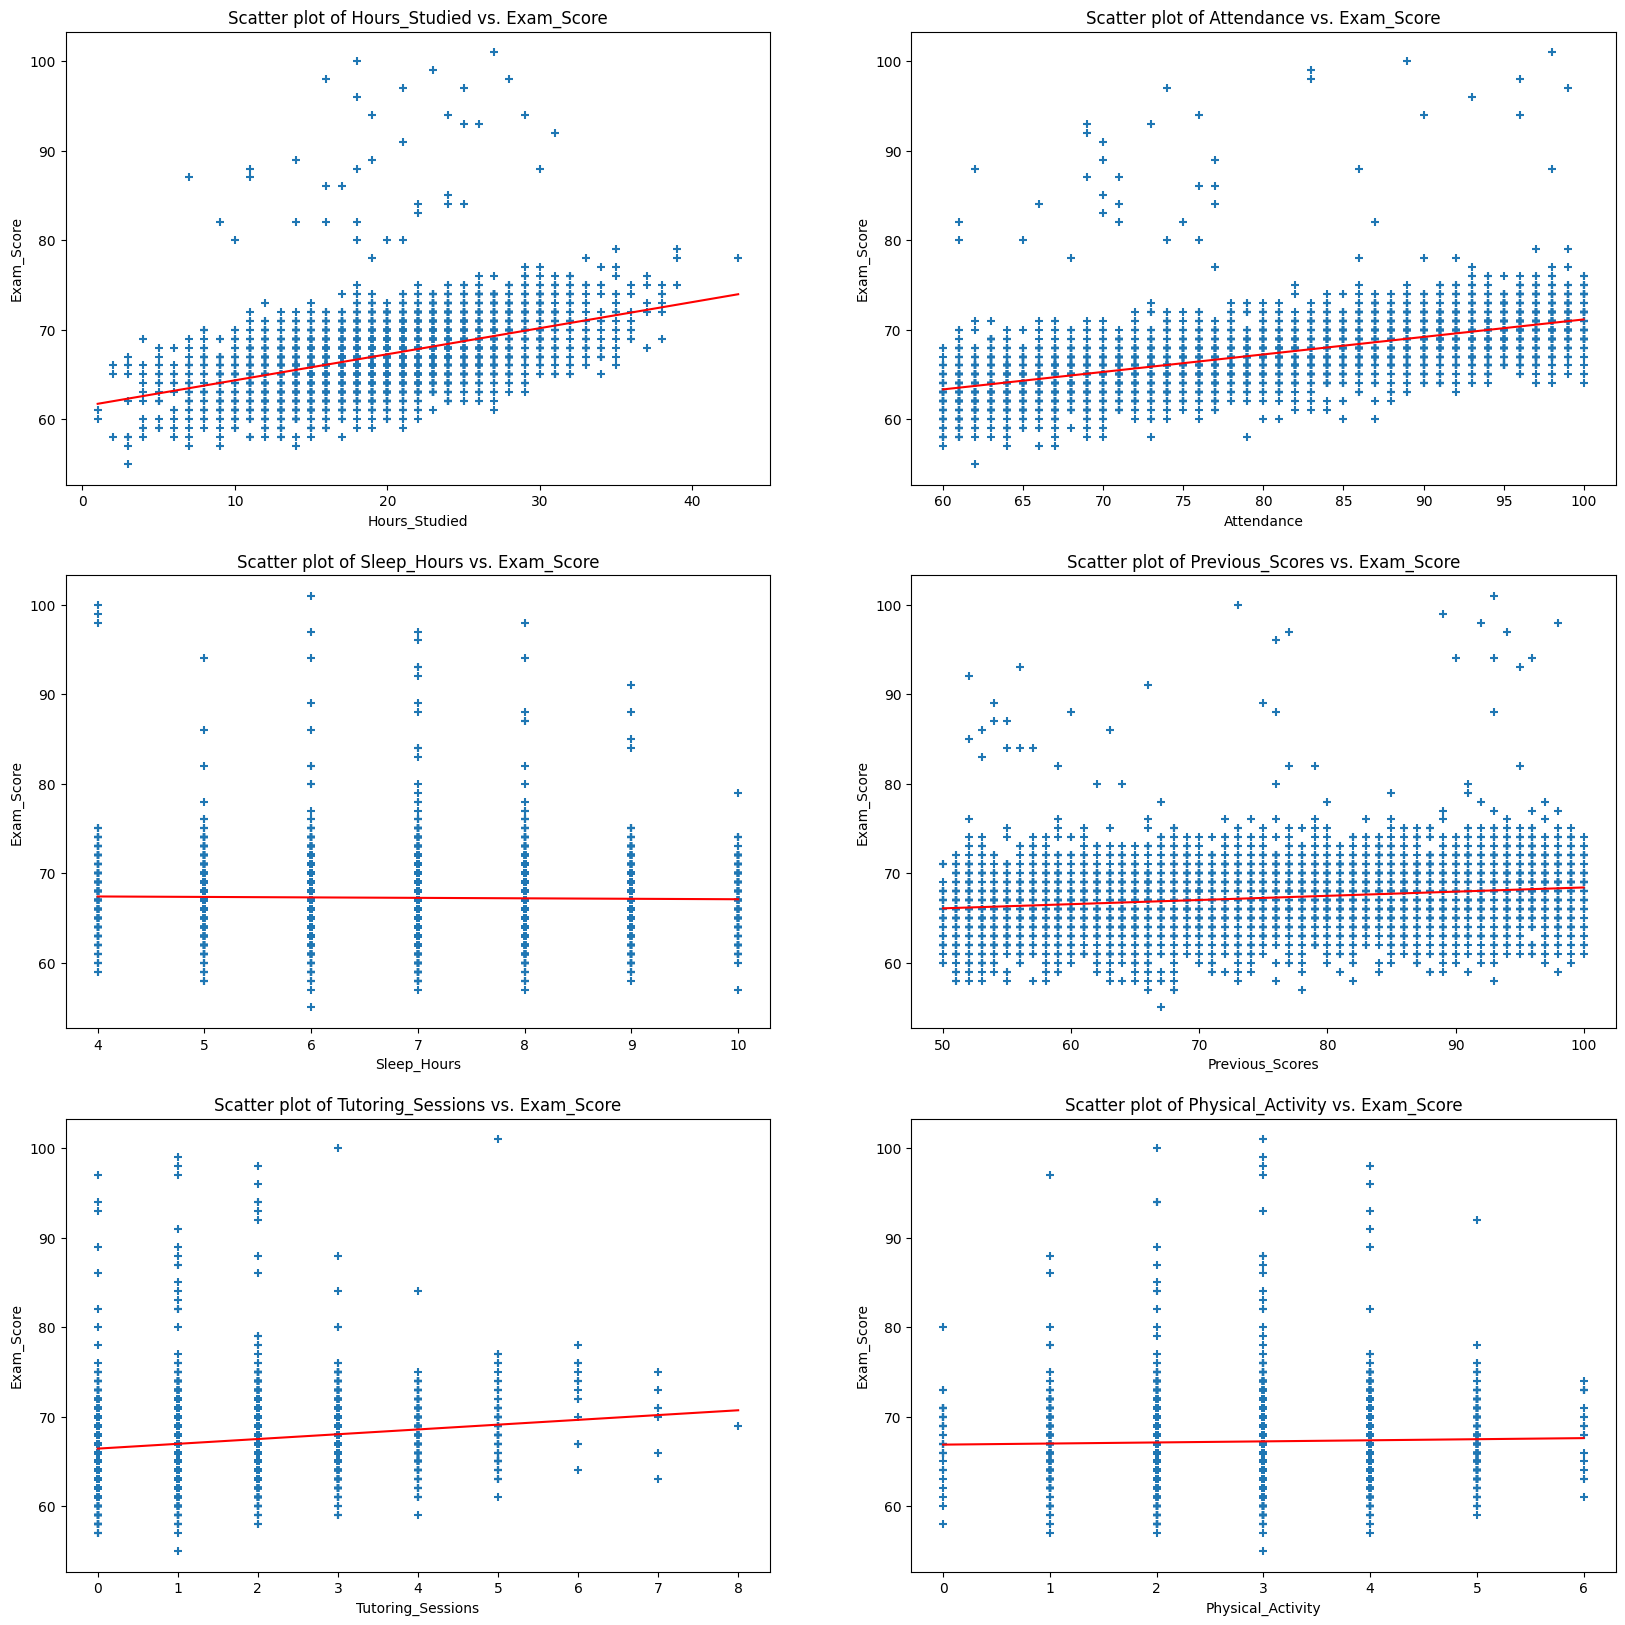

In [66]:
# Plot pairwise scatterplots of the Numerical predictors ('Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity') in this data set with the target Exam_Score:

predictors_columns = x_train.columns.drop("intercept")
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20,20))
i = 0
j = 0
column_index = 0
for i in range(0,3):
    for j in range(0,2):
        column_name = predictors_columns[column_index]
        x_axis = x_train[column_name]
        # print(x)
        ax[i,j].scatter(x_axis,y_train,marker='+')
        ax[i,j].plot(np.unique(x_axis), np.poly1d(np.polyfit(x_axis,y_train,1))(np.unique(x_axis)), color='red')
        ax[i,j].set_title(f'Scatter plot of {column_name} vs. Exam_Score')
        ax[i,j].set_xlabel(column_name)
        ax[i,j].set_ylabel('Exam_Score')
        column_index += 1


From the pairwise scatterplots under the trainning set, we can see there appears relatively strong linear relationships between hour studies, attendence and exam score and a weak linear relationship between previous score and exam score.

# 在解释为什么选择用那个模型而不用什么模型的时候可以用到：

Detailed Comparison

Gradient Boosting:
Strengths: Great at capturing complex patterns, performs well on both regression and classification tasks, and can handle non-linearity.
Weaknesses: Prone to overfitting without proper tuning, computationally intensive, and has limited interpretability.
Use Cases: Often used in competition settings and for highly structured data with complex dependencies.

Random Forest:
Strengths: Excellent at handling high-dimensional data, resilient to outliers, and less prone to overfitting due to averaging multiple trees.
Weaknesses: Less interpretable than linear regression, especially for understanding the relationship between specific predictors and the target.
Use Cases: Effective for a wide range of tasks, including classification, regression, and feature selection in high-dimensional datasets.

Linear Regression:
Strengths: Simple, interpretable, and computationally efficient, with coefficients that provide clear insights into the relationship between predictors and the target.
Weaknesses: Assumes linear relationships, sensitive to outliers, and prone to overfitting when there are many predictors.
Use Cases: Ideal for problems with a strong linear relationship, straightforward interpretability, and minimal feature interactions.

Summary
Gradient Boosting is powerful for handling complex, non-linear data but requires careful tuning.
Random Forest is a robust choice when you need to handle high-dimensional data and interactions without overfitting.
Linear Regression is best suited for simpler problems with a linear relationship, where interpretability and speed are essential.


# Random Forest Model:

In [67]:
#We use Random Forest Important techniques to determine the importance of each predictors in our training set.
# We need to build a Random Forest model first:

rf_auto = RF(max_features=19,
             n_estimators=1000,
             max_depth=15,
             min_samples_leaf=1,
             bootstrap=True,
             random_state=314)
rf_auto.fit(x_train, y_train)

RandomForestRegressor(max_depth=15, max_features=19, n_estimators=1000,
                      random_state=314)

In [68]:
# Compute the R^2 for this model (on train)
y_hat_rf = rf_auto.predict(x_test)
R2 = rf_auto.score(x_test, y_test)
print("r squared on train is: ", R2)

r squared on train is:  0.6143467347284178


In [69]:
# Compute the MSE for this model (on train and then on test)

y_hat_rf = rf_auto.predict(x_test)
mse_rf = np.mean((y_test - y_hat_rf)**2)
print('test mse: ',mse_rf)

test mse:  6.39397052671727


In [70]:
# Feature importance list of Random Forest model:

feature_names = list(x_train.columns)
feature_names
feature_imp = pd.DataFrame(
    {'importance':rf_auto.feature_importances_},
    index=feature_names)
feature_imp = feature_imp.sort_values(by='importance', ascending=False)
feature_imp

,importance
Attendance,0.377101
Hours_Studied,0.224930
Previous_Scores,0.075254
Tutoring_Sessions,0.034283
Sleep_Hours,0.022854
Physical_Activity,0.021769
Parental_Involvement_High,0.017672
Access_to_Resources_High,0.016382
Access_to_Resources_Low,0.013554
Parental_Involvement_Low,0.012941


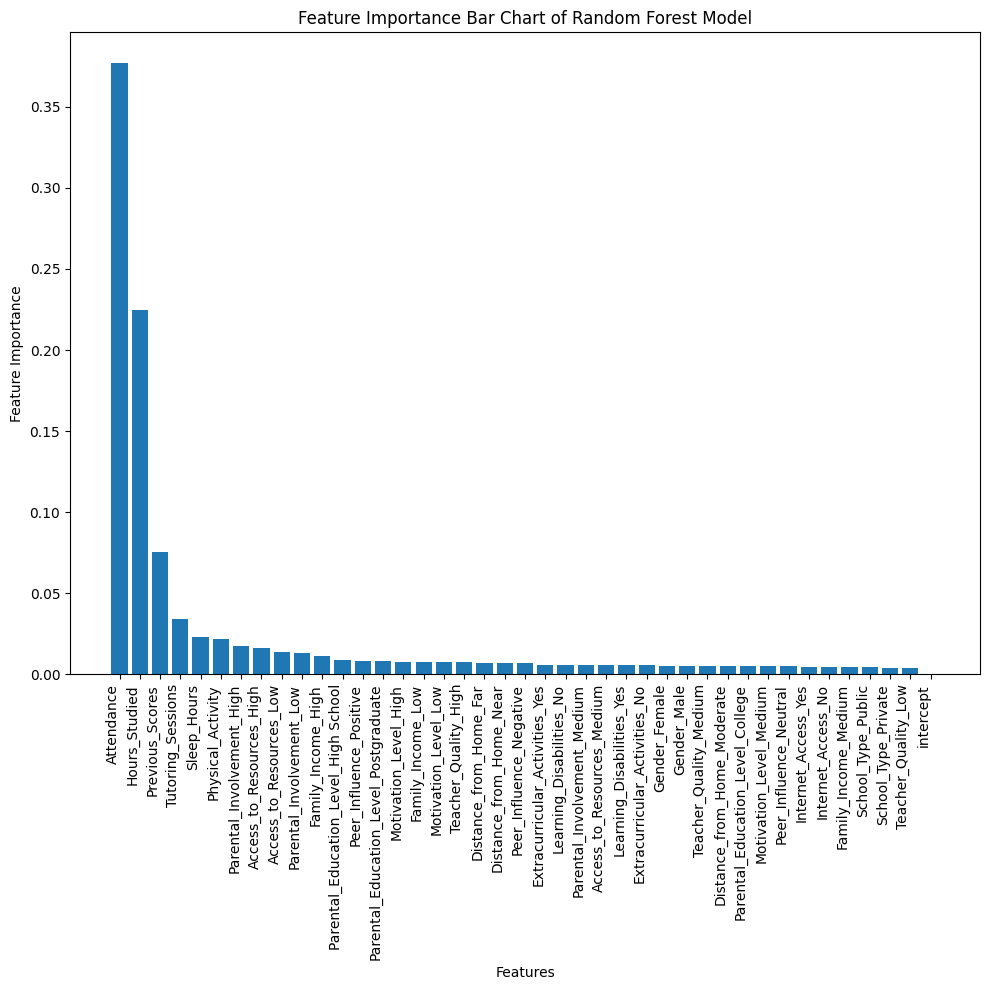

In [71]:
# Plotting the bar chart
plt.figure(figsize=(10, 10))
plt.bar(feature_imp.index, feature_imp['importance'])
plt.ylabel('Feature Importance')
plt.xlabel('Features')
plt.title('Feature Importance Bar Chart of Random Forest Model')
plt.xticks(rotation=90, ha='right')  # Rotate feature names for better readability
plt.tight_layout()
plt.show()

# Linear Regression model with 40 predictors after one hot encoding:

In [72]:
# Build a linear regression model where all the 40 predictors predicts exam score after one hot encoding:
# Take note of the p-values

RLM = sm.OLS(y_train, x_train)
results = RLM.fit()
summarize(results)

,coef,std err,t,P>|t|
intercept,6.4263,0.052,123.605,0.000
Hours_Studied,0.2979,0.005,63.339,0.000
Attendance,0.1968,0.002,81.493,0.000
Sleep_Hours,-0.0131,0.019,-0.685,0.493
Previous_Scores,0.0481,0.002,24.779,0.000
Tutoring_Sessions,0.4972,0.023,22.002,0.000
Physical_Activity,0.1932,0.027,7.079,0.000
Parental_Involvement_High,3.1502,0.046,68.543,0.000
Parental_Involvement_Low,1.1919,0.051,23.508,0.000
Parental_Involvement_Medium,2.0842,0.041,51.099,0.000


In [73]:
# Compute the R^2 for this model (on train)
print("r squared on train is: ", results.rsquared)

r squared on train is:  0.736511484676744


The R-squared = 0.7365114846767438 means 73.65 percent of the variability can be explained by this model.

In [74]:
# Compute the MSE for this model (on train and then on test)
predictions_make_Train = predict(x_train, results)
print("mse on Train is: ", mse(y_train, predictions_make_Train))
predictions_make_Test = predict(x_test, results)
print("mse on Test is: ", mse(y_test, predictions_make_Test))

mse on Train is:  3.9530801433849723
mse on Test is:  5.529625546063158


# Backward subset selection

In [75]:
# We use backward subset selection method to reducing the dimension of our data set and deciding simpler better linear regression model:
# Eliminate all the predictor with the largest p-value, which is greater than 0.05, from the last model.

x_train2 = x_train.drop(columns=["Sleep_Hours"])
x_test2 = x_test.drop(columns=["Sleep_Hours"])

In [76]:
# Build a linear model where the 39 predictors, excluding "Sleep_Hours",  predicts exam score after one hot encoding:
# Take note of the p-values

RLM2 = sm.OLS(y_train, x_train2)
results2 = RLM2.fit()
summarize(results2)

,coef,std err,t,P>|t|
intercept,6.4105,0.047,137.534,0.0
Hours_Studied,0.2978,0.005,63.339,0.0
Attendance,0.1968,0.002,81.548,0.0
Previous_Scores,0.0481,0.002,24.796,0.0
Tutoring_Sessions,0.4973,0.023,22.004,0.0
Physical_Activity,0.1934,0.027,7.084,0.0
Parental_Involvement_High,3.1449,0.045,69.409,0.0
Parental_Involvement_Low,1.1869,0.050,23.658,0.0
Parental_Involvement_Medium,2.0787,0.040,51.982,0.0
Access_to_Resources_High,3.1392,0.045,69.997,0.0


In [77]:
# Compute the R^2 for this model (on train)
print("r squared on train is: ", results2.rsquared)

r squared on train is:  0.7364870936507952


In [78]:
# Compute the MSE for this model (on train and then on test)
predictions_make_Train = predict(x_train2, results2)
print("mse on Train is: ", mse(y_train, predictions_make_Train))
predictions_make_Test = predict(x_test2, results2)
print("mse on Test is: ", mse(y_test, predictions_make_Test))

mse on Train is:  3.9534460784248453
mse on Test is:  5.526913225697075


We stop our backward subset selection here, since there is no more predictor with a p-value greater than 0.05, and eliminating any additional predictor no longer improves the selected criterion (shown by decreasing on the value of "mse on Test"). Therefore, the model with 39 predictors, excluding "Sleep_Hours" in the original model, is our final model for backward subset selection.

# Scaling Training Data

In [79]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train[x_train.columns.drop("intercept")])
X_test_scaled = scaler.transform(x_test[x_train.columns.drop("intercept")])

In [80]:
X_train_scaled = pd.DataFrame(sm.add_constant(X_train_scaled), index=x_train.index)
X_test_scaled = pd.DataFrame(sm.add_constant(X_test_scaled), index=x_test.index)
X_train_scaled.columns = x_train.columns
X_test_scaled.columns = x_test.columns
X_train_scaled


,intercept,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity,Parental_Involvement_High,Parental_Involvement_Low,Parental_Involvement_Medium,...,Learning_Disabilities_No,Learning_Disabilities_Yes,Parental_Education_Level_College,Parental_Education_Level_High School,Parental_Education_Level_Postgraduate,Distance_from_Home_Far,Distance_from_Home_Moderate,Distance_from_Home_Near,Gender_Female,Gender_Male
6117,1.0,-0.329253,-0.865550,-2.076841,-1.319447,-0.407729,1.006632,-0.632239,-0.500796,0.972545,...,0.342978,-0.342978,-0.660586,1.003928,-0.497120,-0.334349,-0.656304,0.819233,-0.858917,0.858917
504,1.0,0.175408,0.168852,-0.028505,-1.596439,2.017729,0.032829,1.581681,-0.500796,-1.028231,...,0.342978,-0.342978,-0.660586,1.003928,-0.497120,2.990889,-0.656304,-1.220654,-0.858917,0.858917
2449,1.0,1.016510,-0.262149,-1.394063,1.034989,-0.407729,-0.940974,1.581681,-0.500796,-1.028231,...,0.342978,-0.342978,-0.660586,1.003928,-0.497120,2.990889,-0.656304,-1.220654,1.164257,-1.164257
651,1.0,-0.329253,-0.348349,-0.711284,0.273260,-0.407729,-0.940974,1.581681,-0.500796,-1.028231,...,0.342978,-0.342978,-0.660586,-0.996088,2.011589,2.990889,-0.656304,-1.220654,1.164257,-1.164257
3395,1.0,0.511849,-0.089748,-0.028505,-1.457943,0.400757,1.006632,1.581681,-0.500796,-1.028231,...,0.342978,-0.342978,1.513807,-0.996088,-0.497120,-0.334349,1.523685,-1.220654,1.164257,-1.164257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1066,1.0,-0.161033,0.082652,-0.711284,-0.142229,-0.407729,0.032829,1.581681,-0.500796,-1.028231,...,0.342978,-0.342978,-0.660586,1.003928,-0.497120,-0.334349,-0.656304,0.819233,1.164257,-1.164257
2902,1.0,0.511849,0.944654,-0.711284,-0.280725,2.826215,0.032829,-0.632239,-0.500796,0.972545,...,0.342978,-0.342978,-0.660586,1.003928,-0.497120,-0.334349,1.523685,-1.220654,1.164257,-1.164257
1971,1.0,-0.329253,-1.468952,-0.028505,-1.596439,0.400757,0.032829,-0.632239,-0.500796,0.972545,...,0.342978,-0.342978,-0.660586,-0.996088,2.011589,-0.334349,1.523685,-1.220654,1.164257,-1.164257
3785,1.0,0.511849,1.548056,-0.028505,-1.596439,0.400757,1.006632,-0.632239,-0.500796,0.972545,...,-2.915636,2.915636,-0.660586,1.003928,-0.497120,-0.334349,-0.656304,0.819233,1.164257,-1.164257


# Re-Evaluation After Scaling Training Data

### Random Forest Model

In [81]:
#We use Random Forest Important techniques to determine the importance of each predictors in our training set.
# We need to build a Random Forest model first:

rf_auto = RF(max_features=19,
             n_estimators=1000,
             max_depth=15,
             min_samples_leaf=1,
             bootstrap=True,
             random_state=314)
rf_auto.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=15, max_features=19, n_estimators=1000,
                      random_state=314)

In [82]:
# Compute the R^2 for this model (on train)
y_hat_rf = rf_auto.predict(X_test_scaled)
R2 = rf_auto.score(X_test_scaled, y_test)
print("r squared on train is: ", R2)

r squared on train is:  0.6145375251177116


In [83]:
# Compute the MSE for this model (on train and then on test)

y_hat_rf = rf_auto.predict(X_test_scaled)
mse_rf = np.mean((y_test - y_hat_rf)**2)
print('test mse: ',mse_rf)

test mse:  6.390807301520495


### Multiple Linear Regression Model

In [84]:
# Build a linear regression model where all the 40 predictors predicts exam score after one hot encoding:
# Take note of the p-values

RLM_scale = sm.OLS(y_train, X_train_scaled)
results_scale = RLM_scale.fit()
summarize(results_scale)

,coef,std err,t,P>|t|
intercept,6.722600e+01,4.700000e-02,1425.756,0.000
Hours_Studied,1.776500e+00,3.400000e-02,53.029,0.000
Attendance,2.282700e+00,3.300000e-02,68.410,0.000
Sleep_Hours,-2.140000e-02,3.300000e-02,-0.640,0.522
Previous_Scores,6.973000e-01,3.300000e-02,20.898,0.000
Tutoring_Sessions,6.118000e-01,3.300000e-02,18.377,0.000
Physical_Activity,1.971000e-01,3.300000e-02,5.913,0.000
Parental_Involvement_High,2.614000e+12,1.730000e+12,1.515,0.130
Parental_Involvement_Low,2.317000e+12,1.530000e+12,1.515,0.130
Parental_Involvement_Medium,2.892000e+12,1.910000e+12,1.515,0.130


In [85]:
# Compute the R^2 for this model (on train)
print("r squared on train is: ", results_scale.rsquared)

r squared on train is:  0.6277015199502022


The R-squared = 0.5740340101583764 means 57.40 percent of the variability can be explained by this model.

In [86]:
# Compute the MSE for this model (on train and then on test)
predictions_make_Train_scale = results_scale.predict(X_train_scaled)
print("mse on Train is: ", mean_squared_error(y_train, predictions_make_Train_scale))
predictions_make_Test_scale = results_scale.predict(X_test_scaled)
print("mse on Test is: ", mean_squared_error(y_test, predictions_make_Test_scale))

mse on Train is:  5.585540330255793
mse on Test is:  7.030858198490263


After we scaled the data set, the model didn't perform better since it has mse=7.832270134640281 on the test, which is higher than the original model before scaling the data set, and it has R^2 = 0.5740340101583764, which is lower than the original model before scaling the data set. However, the model after scaling the data set shows more balance in robustness. So, we try to using backword subset selection and add some interaction terms and polynomial terms to this model to see if we can get a model that perform better than the original model.

### Backward subset selection

In [87]:
# We use backward subset selection method to reducing the dimension of our data set and deciding simpler better linear regression model:
# Eliminate all the predictor with the largest p-value, which is greater than 0.05, from the last model.

X_train_scaled1 = X_train_scaled[["intercept", "Hours_Studied", "Attendance", "Previous_Scores", "Tutoring_Sessions", "Physical_Activity"]]
X_test_scaled1 = X_test_scaled[["intercept", "Hours_Studied", "Attendance", "Previous_Scores", "Tutoring_Sessions", "Physical_Activity"]]

In [88]:
# Build a linear model where the 5 relatively important predictors, "Hours_Studied", "Attendance", "Previous_Scores", "Tutoring_Sessions", and "Physical_Activity", predicts exam score after one hot encoding:
# Take note of the p-values

RLM_scaled1 = sm.OLS(y_train, X_train_scaled1)
results_scaled1 = RLM_scaled1.fit()
summarize(results_scaled1)

,coef,std err,t,P>|t|
intercept,67.2423,0.034,1973.646,0.0
Hours_Studied,1.7406,0.034,51.076,0.0
Attendance,2.2840,0.034,66.986,0.0
Previous_Scores,0.6991,0.034,20.505,0.0
Tutoring_Sessions,0.6129,0.034,17.977,0.0
Physical_Activity,0.1501,0.034,4.402,0.0


In [89]:
# Compute the R^2 for this model (on train)
print("r squared on train is: ", results_scaled1.rsquared)

r squared on train is:  0.605722852994176


In [90]:
# Compute the MSE for this model (on train and then on test)
predictions_make_Train_scaled1 = predict(X_train_scaled1, results_scaled1)
print("mse on Train is: ", mse(y_train, predictions_make_Train_scaled1))
predictions_make_Test_scaled1 = predict(X_test_scaled1, results_scaled1)
print("mse on Test is: ", mse(y_test, predictions_make_Test_scaled1))

mse on Train is:  5.915283096521518
mse on Test is:  7.460455321997283


We stop our backward subset selection here since there is no more predictor with a p-value greater than 0.05, and eliminating any additional predictor no longer improves the selected criterion (shown by decreasing on the value of "mse on Test"). Therefore, the model with 5 predictors "Hours_Studied", "Attendance", "Previous_Scores", "Tutoring_Sessions", and "Physical_Activity" is our final model for backward subset selection.

### Check and add interaction terms

In [91]:
# Then, we need to find if there is any interaction terms that can be added to improve our simple linear regerssion model.

# First, we need to Compute the correlation matrix:
correlation_matrix = X_train_scaled1.corr()

# Then, Set the diagonal values (self-correlations values) to NaN by creating a new DataFrame:
correlation_matrix_no_self = correlation_matrix.where(~np.eye(correlation_matrix.shape[0], dtype=bool))

correlation_matrix_no_self


,intercept,Hours_Studied,Attendance,Previous_Scores,Tutoring_Sessions,Physical_Activity
intercept,NaN,NaN,NaN,NaN,NaN,NaN
Hours_Studied,NaN,NaN,-0.008899,0.020028,-0.004560,0.006346
Attendance,NaN,-0.008899,NaN,-0.022794,0.026610,-0.016089
Previous_Scores,NaN,0.020028,-0.022794,NaN,-0.009324,-0.018593
Tutoring_Sessions,NaN,-0.004560,0.026610,-0.009324,NaN,0.020947
Physical_Activity,NaN,0.006346,-0.016089,-0.018593,0.020947,NaN


In [92]:
# Unstack the correlation matrix to find the maximum correlation and its location:
max_correlation_pair = correlation_matrix_no_self.unstack().idxmax()
max_correlation_value = correlation_matrix_no_self.unstack().max()

print("Maximum correlation value (excluding self-correlations):", max_correlation_value)
print("Location (pair of features) with max correlation:", max_correlation_pair)


Maximum correlation value (excluding self-correlations): 0.026610343031102265
Location (pair of features) with max correlation: ('Attendance', 'Tutoring_Sessions')


From the correlation_matrix, we get a pair of predictors ('Attendance' and 'Tutoring_Sessions') that has the relatively largest correlation value, so we add an interaction term for the pair of predictors to improve our linear regression model.

In [93]:
# Create an interaction term, 'Attendance_Tutoring_Sessions_int',  between 'Attendance' and 'Tutoring_Sessions' and add it into the model after backward subset selection:

X_train_scaled1['Attendance_Tutoring_Sessions_int'] = X_train_scaled1['Attendance'] * X_train_scaled1['Tutoring_Sessions']
X_test_scaled1['Attendance_Tutoring_Sessions_int'] = X_test_scaled1['Attendance'] * X_test_scaled1['Tutoring_Sessions']

In [94]:
# Build a linear regression model where 8 predictors "Attendance", "Hours_Studied", "Previous_Scores", "Tutoring_Sessions", "Sleep_Hours", "Physical_Activity", "Parental_Involvement_High", "Access_to_Resources_High", and an interaction term 'Motivation_Level_Medium_Teacher_Quality_Low_int' predict exam score:
# Take note of the p-values

RLM_scaled1 = sm.OLS(y_train, X_train_scaled1)
results_scaled1 = RLM_scaled1.fit()
summarize(results_scaled1)

,coef,std err,t,P>|t|
intercept,67.2425,0.034,1972.787,0.000
Hours_Studied,1.7406,0.034,51.070,0.000
Attendance,2.2839,0.034,66.974,0.000
Previous_Scores,0.6992,0.034,20.505,0.000
Tutoring_Sessions,0.6131,0.034,17.978,0.000
Physical_Activity,0.1502,0.034,4.405,0.000
Attendance_Tutoring_Sessions_int,-0.0109,0.034,-0.320,0.749


We tried to add an interaction term, 'Attendance_Tutoring_Sessions_int', that has the largest correlation value in the correlation matrix, but we got a p-value = 0.749 for this interaction term. So, the p-value suggest that the interaction term is not siginificant for us to predict exam score. Therefore, we will mentain the last model after backward subset selection, using 5 predictors, "Hours_Studied", "Attendance", "Previous_Scores", "Tutoring_Sessions", and "Physical_Activity", to predict exam score.

In [95]:
# Compute the R^2 for this model (on train)
print("r squared on train is: ", results_scaled1.rsquared)

r squared on train is:  0.605730782453071


In [96]:
# Compute the MSE for this model (on train and then on test)
predictions_make_Train_scaled1 = predict(X_train_scaled1, results_scaled1)
print("mse on Train is: ", mse(y_train, predictions_make_Train_scaled1))
predictions_make_Test_scaled1 = predict(X_test_scaled1, results_scaled1)
print("mse on Test is: ", mse(y_test, predictions_make_Test_scaled1))

mse on Train is:  5.9151641319948745
mse on Test is:  7.462164864910878


In [97]:
# Drop the interaction term that we add above

X_train_scaled1 = X_train_scaled1.drop(columns="Attendance_Tutoring_Sessions_int")
X_test_scaled1 = X_test_scaled1.drop(columns="Attendance_Tutoring_Sessions_int")

### Check and add polynomial terms

In [98]:
X_train_scaled1.columns.drop("intercept")

Index(['Hours_Studied', 'Attendance', 'Previous_Scores', 'Tutoring_Sessions',
       'Physical_Activity'],
      dtype='object')

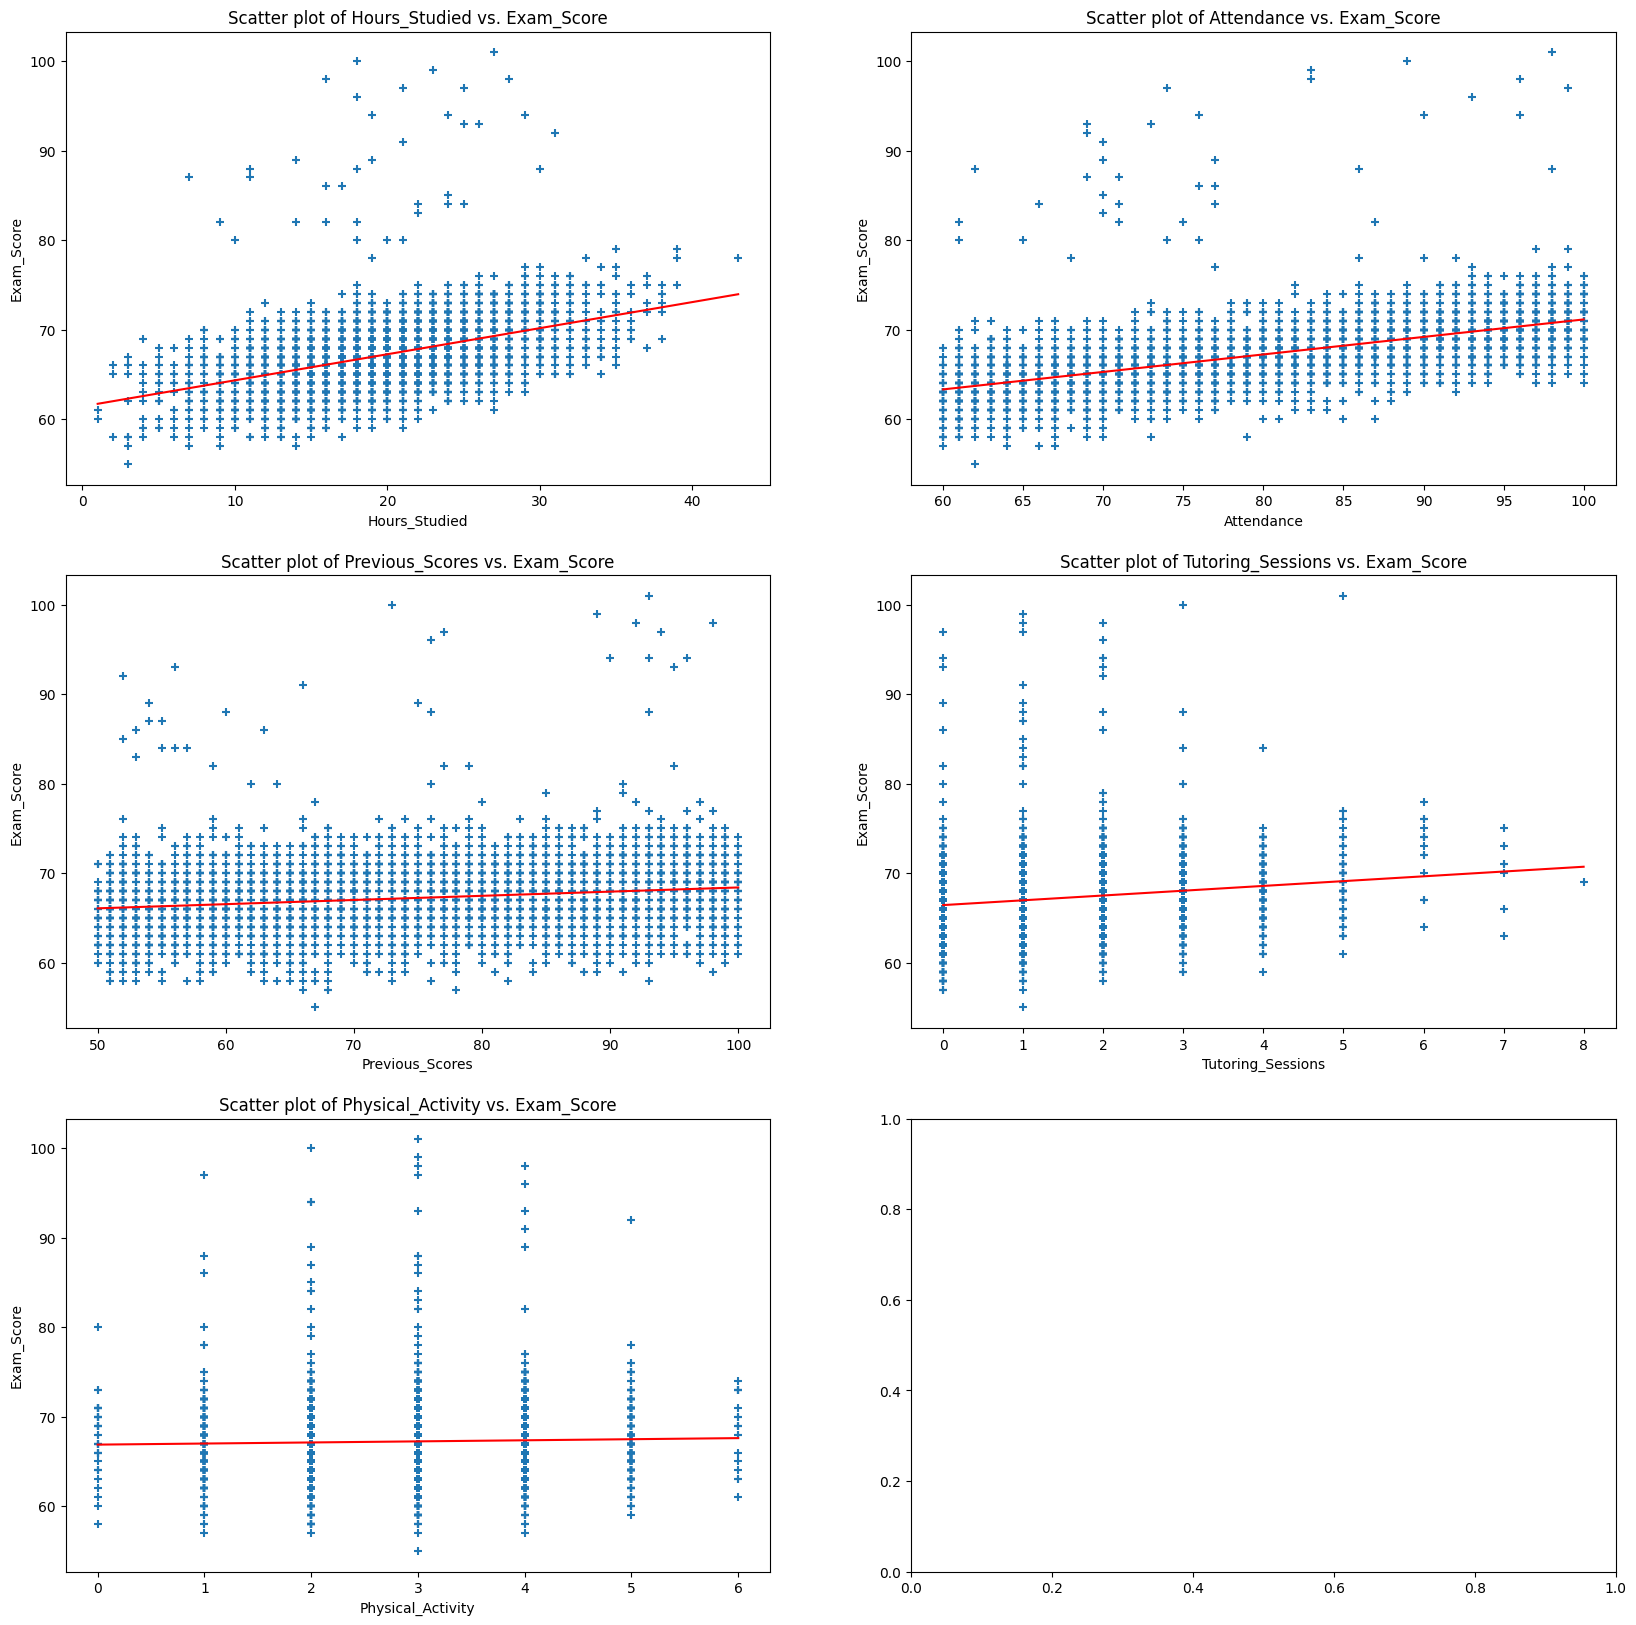

In [99]:
# Plot pairwise scatterplots of the Numerical predictors ("Hours_Studied", "Attendance", "Previous_Scores", "Tutoring_Sessions", and "Physical_Activity") in this data set with the target Exam_Score:

predictors_columns = X_train_scaled1.columns.drop("intercept")
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20,20))
i = 0
j = 0
column_index = 0
for i in range(0,3):
    for j in range(0,2):
        column_name = predictors_columns[column_index]
        x_axis = x_train[column_name]
        # print(x)
        ax[i,j].scatter(x_axis,y_train,marker='+')
        ax[i,j].plot(np.unique(x_axis), np.poly1d(np.polyfit(x_axis,y_train,1))(np.unique(x_axis)), color='red')
        ax[i,j].set_title(f'Scatter plot of {column_name} vs. Exam_Score')
        ax[i,j].set_xlabel(column_name)
        ax[i,j].set_ylabel('Exam_Score')
        column_index += 1

        if column_index == 5:
            break

The scatter plots indicates no clear polynomial trends in this model, so a polynomial terms is not needed in this model.

# Conlusion

The final best model we got, excluding the random forest models, is the model with 39 predictors, excluding "Sleep_Hours", which was generated by backward subset selection in our original model with 40 predictors. And it has the lowest MSE = 5.526913225697061 on test. Therefore, we have enough evidence to conclude that the significant factors in predicting the eaxm score are all the factors in our data set other than "Sleep_Hours" because the p-values of all the predictors/factors in this model are all smaller than the 0.05 significant level. 

There is still lots of improvements that we can do on this model, for example, checking whethear the linearity, normality, and constant variance assumptions are valid in this model and apply other transformations of predictors to the model if any assumption doesn't hold in this model, cheking for any outliers or potential influential data points in our data set and eliminating or adjusting them, find/figure out more relevant relative features/factors to include in our data set, and reducing the dimension of our data set using PCA techiques. 

In [5]:
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Load the dataset
data = pd.read_csv('StudentPerformanceFactors.csv')

# Preprocess the data
X = pd.get_dummies(data.drop(columns=['Exam_Score']), drop_first=True)  # One-hot encode categorical features
y = data['Exam_Score']

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train a RandomForest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Create a SHAP explainer
explainer = shap.Explainer(rf_model, X_train)
shap_values = explainer(X_test)

# Generate a summary plot
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

ModuleNotFoundError: No module named 'shap'